In [1]:
import matplotlib.pyplot as plt
import random
import itertools
import os
import shutil
import colorsys
import numpy as np
import pandas as pd
from termcolor import colored
import coco_dataset
from skimage.measure import find_contours
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon
from matplotlib.image import imread
from collections import namedtuple
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from time import sleep
from PIL import Image, ImageDraw, ImageFont

ResultTuple = namedtuple("Result", "test_num, image_id, caption_pred, caption_gt, region_num, region_info")
RegionTuple = namedtuple("Region", "label, coordinate, weight")

In [2]:
class DemoTest():
    def __init__(self, id=None):
        self.img_dir = "./testset_for_demo/"
        self.web_demo_img = "/archive/MyHome/Programs/git/my_research/Image Captioning/Demo/flaskapp/app/images/output_img.jpg"
        self.web_demo_cap = "/archive/MyHome/Programs/git/my_research/Image Captioning/Demo/flaskapp/app/images/output_cap.jpg"

        self.demo_num = 63
        self.id = 1
        if id is None:
            self.id = random.randint(1, self.demo_num) 
        else:
            self.id = id
            
        self.colors = [(1.0, 0.0, 0.0), (0.5, 1.0, 0.0), (0.0, 1.0, 1.0), (0.5, 0.0, 1.0), (0.0, 0.0, 1.0)]
        
#        font_red_bold = "\033[1;31;47m "
#        font_green_bold = "\033[1;31;47m "
#        font_red_bolod = "\033[1;31;47m "
#        font_red_bolod = "\033[1;31;47m "
        
    
    def test(self):
        #sleep(3.5)
        return self._get_test_result(self.id) 
        
    def show_img_info(self, result):
        img_path = self._get_image_path(result)

        img = imread(img_path)
        #print("Test_num: {}".format(result.test_num))
        print(colored("Image ID: {}".format(result.image_id), 'yellow', 'on_grey',attrs=['bold']))
        #print("Image ID: {}".format(result.image_id))
        print("Processing 1 image")
        print("Image shape {}".format(img.shape))
        plt.imshow(img)
        plt.show()    
        
        
        
    def show_cap_and_wmatrix(self, result):
        cap_pred = result.caption_pred
        cap_gt = result.caption_gt
        self._remove_ipytemp(result.test_num)

#         print(colored("----------------", attrs=['bold']))
#         print(colored("Caption Info", 'yellow', 'on_grey',attrs=['bold']))
#         print(colored("Predicted caption:", attrs=['bold']))
#         print(cap_pred)
#         print(colored("Ground truth caption:", attrs=['bold']))
#         print(cap_gt)


        print(colored("\n----------------", attrs=['bold']))
        print(colored("Region Info", 'yellow', 'on_grey',attrs=['bold']))
        
        region_num = len(result.region_info)
        labels, weights, coords = self._extract_region_info(region_num, result.region_info)
        output_path = self.img_dir + result.test_num + "/output/"
        
        for i in range(region_num):
            region_path = output_path + labels[i]
            r_img = imread(region_path)
            print("region {} shape: {}".format(i, r_img.shape))   
            print("related word: {}".format(labels[i]))
            plt.imshow(r_img)
            plt.show()    
                
            
        print(colored("\n----------------", attrs=['bold']))
        print(colored("Weight Matirx", 'yellow', 'on_grey',attrs=['bold']))
        
        self._make_weight_matrix(cap_pred, labels, weights)
        
        
    def show_final_output(self, result):
        #print("Test_num: {}".format(result.test_num))
        print(colored("----------------", attrs=['bold']))
        print(colored("Final Output", 'yellow', 'on_grey',attrs=['bold']))
        
        img_path = self._get_image_path(result)
        img = imread(img_path)
        print("Image ID: {}".format(result.image_id))
        print("Processing 1 image")
        print("Image shape {}".format(img.shape))
        
        cap_pred = result.caption_pred
        region_num = len(result.region_info)
        ax = None
        if not ax:
            _, ax = plt.subplots(1, figsize=(12, 12))
        
        final_img  = img.astype(np.uint32).copy()
        labels, str_weights, coords = self._extract_region_info(region_num, result.region_info)
        colors = self._random_colors(region_num)
        
        weights = []
        boxes = []
        for i in range(region_num):
            weights.append(self._convert_str_to_num(str_weights[i], t_type='float'))
            boxes.append(self._convert_str_to_num(coords[i], t_type='int'))
         
        interval = 30
        for i in range(region_num):
            # adding the bounding boxes
            color = colors[i]
            height, width = img.shape[:2]
            ax.set_ylim(height + 10, -10)
            ax.set_xlim(-10, width + 10)
            ax.axis('off')
            
            y1, x1, y2, x2 = boxes[i]
            p = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2.5,
                              alpha=1, linestyle="solid",
                              edgecolor=color, facecolor='none')
            ax.add_patch(p)
            
            mid_x1 = x1 + (x2 - x1)/2
            mid_y1 = y1 + (y2 - y1)/2
            p_arr = patches.FancyArrow(mid_x1, mid_y1, (width+5)-mid_x1, interval-mid_y1, width=1.5, linewidth=0.5, 
                                       alpha=1, linestyle="-", color=color)
            ax.add_patch(p_arr)
            
            region_label = "{} {:.3f}".format(labels[i], float(max(weights[i])))
            ax.text(width+20, interval, region_label, color=color, size=16, backgroundcolor="none")
            interval += 20
            
        ax.imshow(final_img.astype(np.uint8))
        fig = plt.gcf()
        plt.show()  
        
        cap_words_print = cap_pred.split(" ")
        cap_output = []
        #colored_idx = []
        for i in range(len(cap_words_print)):
            for j in range(len(labels)):
                if " " in labels[j]:
                    if i < len(cap_words_print)-1:
                        two_words = cap_words_print[i] + " " + cap_words_print[i+1]
                        if two_words == labels[j]:
                            cap_words_print[i] = self._get_font_color(colors[j], labels[j]) + cap_words_print[i]
                            cap_words_print[i+1] = self._get_font_color(colors[j], labels[j]) + cap_words_print[i+1]
                elif cap_words_print[i] == labels[j]:
                    cap_words_print[i] = self._get_font_color(colors[j], labels[j]) + cap_words_print[i]
                    #colored_idx.append(i)
                    
        basic_color = "\033[1;30;49m"
        colored_cap = basic_color + "Predicted caption: "
        for i in range(len(cap_words_print)):
            colored_cap += basic_color + cap_words_print[i] + " "
        print(colored_cap)
        print("\033[1;30;49mGround truth caption: {}".format(result.caption_gt))
                
    
    #### for web demo
#         fig.savefig(self.web_demo_img)

        
#         for i in range(len(labels)):
#             if " " in labels[i]:
#                 cap_pred = cap_pred.replace(labels[i], labels[i].replace(" ", "#"))
                
        
#         cap_words = cap_pred.split(" ")
#         fnt = ImageFont.truetype('FreeMono.ttf', 20, encoding='unic')
        
#         size = 0
#         if fnt.getsize("Predicted caption: "+result.caption_pred)[0] >= fnt.getsize("Ground truth: "+result.caption_gt)[0]: size = fnt.getsize("Predicted caption: "+result.caption_pred)[0]
#         else: size = fnt.getsize("Ground truth: "+result.caption_gt)[0]
        
#         img = Image.new('RGB', (size, 30*2), color=(255,255,255))
#         d = ImageDraw.Draw(img)
#         cur_sen = "Predicted caption: "      
#         d.text((0, 0), cur_sen, font=fnt, fill=(0,0,0))  
#         for i in range(len(cap_words)):
#             color = (0,0,0)
#             cap_words[i] = cap_words[i].replace("#", " ")
            
#             for j in range(len(labels)):
#                 if cap_words[i] == labels[j]:
#                         color = colors[j]  
#             color = tuple(map(lambda x, y: int(x * y), color, (255,255,255)))     
                
#             d.text((fnt.getsize(cur_sen)[0], 0), cap_words[i], font=fnt, fill=color)
#             cur_sen += " " + cap_words[i]
        
#         d.text((0, 30), "Ground truth: "+result.caption_gt, font=fnt, fill=(0,0,0))
#         img.save(self.web_demo_cap)
    
    
    
    
            ###### private functions ######        
    
    def _get_font_color(self, box_color, word):
        if self._compare_lists(box_color, self.colors[0]): 
            return "\033[1;31;49m" 
        elif self._compare_lists(box_color, self.colors[1]): 
            return "\033[1;32;49m" 
        elif self._compare_lists(box_color, self.colors[2]): 
            return "\033[1;36;49m" 
        elif self._compare_lists(box_color, self.colors[3]):
            return "\033[1;35;49m" 
        elif self._compare_lists(box_color, self.colors[4]): 
            return "\033[1;34;49m" 
        
    def _compare_lists(self, l1, l2):
        if len(l1) is not len(l2): return False
        for i in range(len(l1)):
            if abs(l1[i]-l2[i]) > 0.00001: return False
        return True
    
    def _extract_region_info(self, region_num, region_info):
        labels = []
        weights = []
        coords = []
        
        for i in range(region_num):
            labels.append(region_info[i].label)
            weights.append(region_info[i].weight)
            coords.append(region_info[i].coordinate)
            
        return labels, weights, coords
    
    def _make_weight_matrix(self, caption, labels, weights):
        cols = caption.split(" ")
        rows = ['region %d' % i for i in range(len(labels))]
        data = []
        for i in range(len(weights)):
            data.append(self._convert_str_to_num(weights[i], t_type='float'))
        
        fig, axes = plt.subplots(2, figsize=(10,10))
        
        # plot
        x = np.arange(0, len(cols))
        #y = data[0]
        #xticks = cols
        plot_colors = ['r--o', 'g--o', 'b--o', 'm--o', 'y--o', 'c--o']
        axes[0].set_xticks(x)
        axes[0].set_xticklabels(cols)
        for i in range(len(data)):
            axes[0].plot(x, data[i], plot_colors.pop(random.randint(0, len(plot_colors)-1)), label="region {}".format(i))
        #axes[0].plot(x, data[0], 'r--o', x, data[1], 'g--o', x, data[2], 'b--o')
        
        legend = axes[0].legend(fontsize='x-large', shadow=False, bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, borderaxespad=0.)
        #legend.get_frame().set_facecolor('C0')
        
        # table
        axes[1].axis('off')
        axes[1].axis('tight')
        the_table = axes[1].table(cellText=data, colLabels=cols, rowLabels=rows, loc='upper center')
        the_table.set_fontsize(20)
        the_table.scale(1.35, 1.35)
        fig.tight_layout()
        plt.show()
        
    def _convert_str_to_num(self, str, t_type='float'):
        str_list = str.split(',')
        num_list = []
        for i in range(len(str_list)):
            if t_type is 'float':
                num_list.append(float(str_list[i]))
            elif t_type is 'int':
                num_list.append(int(str_list[i]))
            
        return num_list
    
    def _get_image_path(self, result):
        return self.img_dir + result.test_num + "/" + result.image_id + ".jpg"
    
    def _print_image(self, path):
        img = imread(path)
        plt.imshow(img)
        plt.show()
    
    def _remove_ipytemp(self, test_num):
        path = '/archive/MyHome/Programs/git/my_research/Image Captioning/Demo/testset_for_demo/' + test_num + "/.ipynb_checkpoints"
        if os.path.exists(path):
            shutil.rmtree(path)
        
        path = '/archive/MyHome/Programs/git/my_research/Image Captioning/Demo/testset_for_demo/' + test_num + "/output/.ipynb_checkpoints"
        if os.path.exists(path):
            shutil.rmtree(path) 
        
    def _random_colors(self, N, bright=True):
        """
        Generate random colors.
        To get visually distinct colors, generate them in HSV space then
        convert to RGB.
        """
#         brightness = 1.0 if bright else 0.7
#         hsv = [(i / N, 1, brightness) for i in range(N)]
#         colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
        #random.shuffle(colors)
        #colors = [(1.0, 0.0, 0.0), (0.5, 1.0, 0.0), (0.0, 1.0, 1.0), (0.5, 0.0, 1.0), (0.0, 0.0, 1.0)]
        colors = self.colors.copy()
        random.shuffle(colors)
        return colors

    def _get_test_result(self,id):
        info_path = "./testset_for_demo/test_" + str(id) + "/output/info"
        with open(info_path, "r") as fd:
            test_num = fd.readline().split(':')[1].replace('\n', '')
            image_id = fd.readline().split(':')[1].replace('\n', '')
            caption_pred = fd.readline().split(':')[1].replace('\n', '')
            caption_gt = fd.readline().split(':')[1].replace('\n', '')
            region_num = fd.readline().split(':')[1].replace('\n', '')

            r_info_str = []
            for i in range(int(region_num)):
                r_info_str.append(fd.readline().split(':')[1].replace('\n', ''))

            region_info = []
            for i in range(len(r_info_str)):
                region_info.append(RegionTuple(r_info_str[i].split('|')[0], r_info_str[i].split('|')[1], r_info_str[i].split('|')[2]))

            #r2 = RegionTuple(r2_info.split('|')[0], r2_info.split('|')[1], r2_info.split('|')[2])
            #r3 = RegionTuple(r3_info.split('|')[0], r3_info.split('|')[1], r3_info.split('|')[2])

        test_output = ResultTuple(test_num, image_id, caption_pred, caption_gt, region_num, region_info)
        return test_output

# Demo

----------------
Final Output
Image ID: coco_573635
Processing 1 image
Image shape (640, 480, 3)


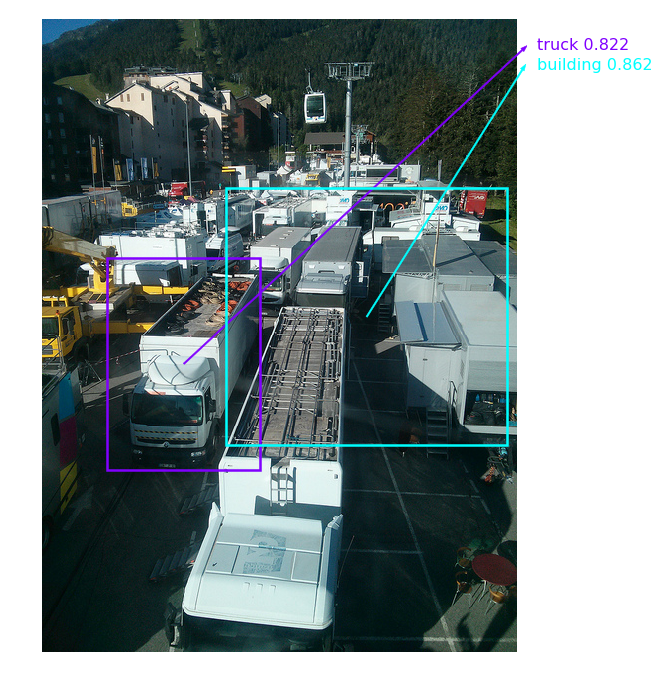

Predicted caption: parking lot of truck and building on a street 
Ground truth caption: a yard filled with trucks parked next to each other

----------------
Region Info
region 0 shape: (215, 155, 4)
related word: truck


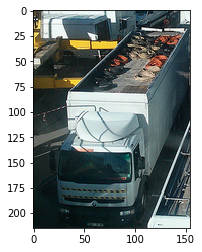

region 1 shape: (260, 285, 4)
related word: building


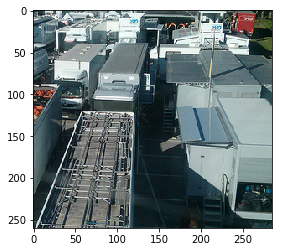


----------------
Weight Matirx


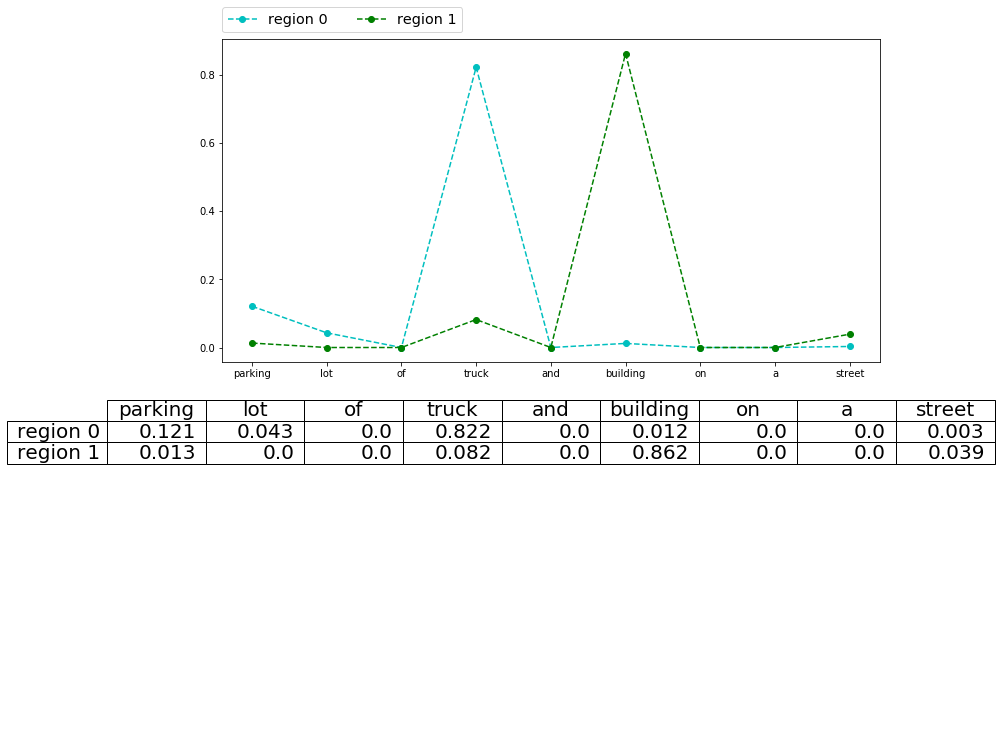

In [7]:
#for i in range(63, 64):
demo = DemoTest(70)
result = demo.test()
#demo.show_img_info(result)
demo.show_final_output(result)
demo.show_cap_and_wmatrix(result)


#7 12

In [22]:
for i in range(1, 64):
    demo = DemoTest(i)
    result = demo.test()

    path = '/archive/MyHome/Programs/git/my_research/Image Captioning/Demo/testset_for_demo/'
    path += result.test_num + "/.ipynb_checkpoints"

    if os.path.exists(path):
        shutil.rmtree(path)
        print("test num: {}".format(i))

    
#     cap_len = len(result.caption_pred.split(" "))
#     for j in range(len(result.region_info)):
#         if "person1" in result.region_info[j].label:
#             print("test num: {}, region num: {}".format(i, j))
#         w_len = len(result.region_info[j].weight.split(","))
#         if cap_len != w_len:
    

test num: 2
test num: 3
test num: 11
test num: 34
test num: 50
test num: 62


In [ ]:
def _load_dataset():
    dataset_train = coco_dataset.CocoDataset()
    dataset_train.load_coco(subset="train", auto_download=False)
    #dataset_train.load_coco("valminusminival", year=year, auto_download=auto_download)
    dataset_train.prepare()
    
    print("Images: {}\nClasses: {}".format(len(dataset_val.image_ids), dataset_val.class_names))
    print('Done')
    
    
_load_dataset()


In [ ]:
        img_dir = "./testset_for_demo/"
        t_dir = "/archive/MyHome/Programs/git/my_research/Image Captioning/Demo/flaskapp/app/images/"


        path = img_dir + result.test_num + "/" + result.image_id + ".jpg"
        t_path = t_dir + result.test_num.split('_')[1] + ".jpg"
        shutil.copy(path, t_path)
        print(result.test_num.split('_')[1])
        